# A basic Demonstration of MetaCast

MetaCast has been developed from the codebase used in Grunnill et al. (2024). MetaCast's main feature is broad*CAST*ing epidemiological and ecological subpopulation models over multiple dimensions (axis) to form a *META*population model.

This notebook uses a disease X SEIHR (Susceptible - Exposed - Infected - Hospitalised - Recovered) subpopulation model as a motivating example. In possible scenarios in outbreak of disease X that epidemiological modellers my wish to simulate:
1. Risk-Structured: Single Dimension/Axis disease X model.
2. Seeding at 10% prevelance: Multinomial seeder
3. Two New Vaccines of known efficacy: Multi Dimension/Axis disease X model with flows between some subpopulations.
4. A New Vaccine of Uncertain Efficacy: Latin Hypercube Sampling in simulation of a 2 dimensional/axis disease X model.
5. A Rapid Pathogen test: Discrete Event simulation within a 2 dimensional/axis disease X model.

# 1. Age-Structured: Single Dimension/Axis disease X model.

Import MetaCast's main class MetaCaster.

In [1]:
from metacast import MetaCaster

## 1.1 MetaCaster setup
### 1.1.1 Define subpopulation model.

This is the function that is your subpopulation model that MetaCaster will broadcast across the metapopulation generated by your scaffold (see 1.2).
The arguments are required

In [2]:
def subpop_model(y, y_deltas, parameters, states_index, subpop_suffix, foi):
    """
    Calculate derivatives of variables in disease X's subpopulation model

    Parameters
    ----------
    y : numpy.Array
        An array of the state variables at this time.
    y_deltas : numpy.Array
        The derivatives of y at this time.
    parameters : dict {str:Number or callable}
        A dictionary of parameter values.
    states_index : dict {str:int}

    subpop_suffix : str

    foi : float
        Force of infection experienced be susceptible hosts in this subpopulation.

    Returns
    -------
    y_deltas : numpy.Array
        y_deltas with derivatives of variables in disease X's subpopulation model added to.

    """
    infections = foi * y[states_index['S']]
    progression_from_exposed = parameters['sigma'] * y[states_index['E']]
    probability_of_hospitalisation = parameters['p' + subpop_suffix] # this is our subpopulation specific parameter
    progression_from_infectious = y[states_index['I']]*parameters['gamma']
    recovery = progression_from_infectious*(1-probability_of_hospitalisation)
    hospitalisation = progression_from_infectious*probability_of_hospitalisation
    hospital_recovery = y[states_index['H']]*parameters['eta']


    # Updating y_deltas with derivative calculations from this subpopulation.
    y_deltas[states_index['S']] += - infections
    y_deltas[states_index['E']] += infections - progression_from_exposed
    y_deltas[states_index['I']] += progression_from_exposed - progression_from_infectious
    y_deltas[states_index['H']] += hospitalisation - hospital_recovery
    y_deltas[states_index['R']] += recovery+hospital_recovery
    y_deltas[-1] += hospitalisation

    return y_deltas

### 1.1.2 Define metapopulation scaffold.

In this first we are assuming structure comes from just the risk of hospitalisation (low and high). Simulations are going to be over 90 days. Therefore, we will assume no flows of population between subpopulations. As we are dealing with a one dimension axis metapopulation we can provide a set of strings as our scaffold (a list/tuple of unique strings is also acceptable. **Note** if dealing with a multidimensional metapopulation the scaffold would have to be a list/tuple of sets of strings.

In [3]:
scaffold_1 = set(['low', 'high'])

### 1.1.3 Define model attributes

In [4]:
model_attributes = {'states': ['S', 'E', 'I', 'H', 'R'],
                    'infected_states': ['E', 'I'],
                    'infectious_states': ['I'],
                    'symptomatic_states': ['I'],
                    'observed_states': ['H_T'],
                    'universal_params': ['sigma', 'gamma', 'eta'],
                    'subpop_params': ['p'],
                    'transmission_subpop_specific': False}

### 1.1.3 Intialise MetaCaster.

In [5]:
metapop_model = MetaCaster(scaffold=scaffold_1, model_attributes=model_attributes, subpop_model=subpop_model)

# 1.2 Running model
## 1.2.1 Setting population

In [6]:
import numpy as np
metapop_model.num_state

11

In [7]:
state_index_dict_high = metapop_model.state_index['high']
state_index_dict_low = metapop_model.state_index['low']
display(state_index_dict_low, state_index_dict_high)

{'S': 5, 'E': 6, 'I': 7, 'H': 8, 'R': 9}

{'S': 0, 'E': 1, 'I': 2, 'H': 3, 'R': 4}

In [8]:
N = 1e6
proportion_high_risk = 0.1
low_risk_population = N*(1-proportion_high_risk)
high_risk_population = N*proportion_high_risk
y = np.zeros(metapop_model.num_state)
y[state_index_dict_low['S']] = low_risk_population-1
y[state_index_dict_low['I']] = 1
y[state_index_dict_high['S']] = high_risk_population
y

array([1.00000e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       8.99999e+05, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00])

### 1.2.2 Setting up parameters

In [9]:
metapop_model.all_parameters

['beta', 'eta', 'gamma', 'p_[high]', 'p_[low]', 'sigma']

In [10]:
parameters = {'beta':(2/7)/N, 'eta': 1/5, 'gamma': 1/7, 'p_[high]': 0.3, 'p_[low]': 0.01, 'sigma': 1/3}
metapop_model.parameters = parameters

### 1.2.3 Run metapopulation model

In [11]:
#set time
t = np.arange(0,91,1)
t

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90])

In [12]:
results_1 = metapop_model.integrate(y,t)

In [13]:
results_1

high                                                \
                S          E           I          H           R   
0   100000.000000   0.000000    0.000000   0.000000    0.000000   
1    99999.972985   0.022911    0.003908   0.000056    0.000140   
2    99999.947570   0.038014    0.013053   0.000369    0.000994   
3    99999.922182   0.048841    0.024924   0.001041    0.003012   
4    99999.895846   0.057424    0.038181   0.002084    0.006465   
..            ...        ...         ...        ...         ...   
86   99679.171312  64.975344   95.280960  14.350610  146.221775   
87   99650.860927  70.688384  103.675520  15.616509  159.158659   
88   99620.066034  76.899683  112.805318  16.993571  173.235394   
89   99586.570815  83.651946  122.733948  18.491464  188.551827   
90   99550.141119  90.991403  133.530356  20.120679  205.216442   

              low                                                  \
                S           E            I         H            R   
0   899999.000000    0.000000     1.000000  0.000000     0.000000   
1   899998.756863    0.206203     0.902053  0.001220     0.133660   
2   899998.528128    0.342128     0.868956  0.002140     0.258649   
3   899998.299639    0.439570     0.875754  0.002878     0.382159   
4   899998.062612    0.516814     0.908351  0.003510     0.508713   
..            ...         ...          ...       ...          ...   
86  897111.545018  584.777444   857.527688  4.305178  1441.844671   
87  896856.751838  636.194751   933.078650  4.684948  1569.289813   
88  896579.598102  692.096376  1015.246741  5.098066  1707.960715   
89  896278.141473  752.866680  1104.604306  5.547433  1858.840108   
90  895950.274569  818.921720  1201.771874  6.036197  2022.995640   

   observed_states  
               H_T  
0         0.000000  
1         0.001407  
2         0.003017  
3         0.005066  
4         0.007687  
..             ...  
86       62.633214  
87       68.172298  
88       74.199277  
89       80.756863  
90       87.891455  

[91 rows x 11 columns]

### 1.2.4 Plotting hospitalisations

In [14]:
import seaborn as sns

In [15]:
results_1['t'] = t
results_1_melted = results_1.melt(id_vars=['t'],var_name=['Subpopulation', 'State']) # melt results for using seaborn
results_1_melted

,t,Subpopulation,State,value
0,0,high,S,100000.000000
1,1,high,S,99999.972985
2,2,high,S,99999.947570
3,3,high,S,99999.922182
4,4,high,S,99999.895846
...,...,...,...,...
996,86,observed_states,H_T,62.633214
997,87,observed_states,H_T,68.172298
998,88,observed_states,H_T,74.199277
999,89,observed_states,H_T,80.756863


<Axes: xlabel='t', ylabel='value'>

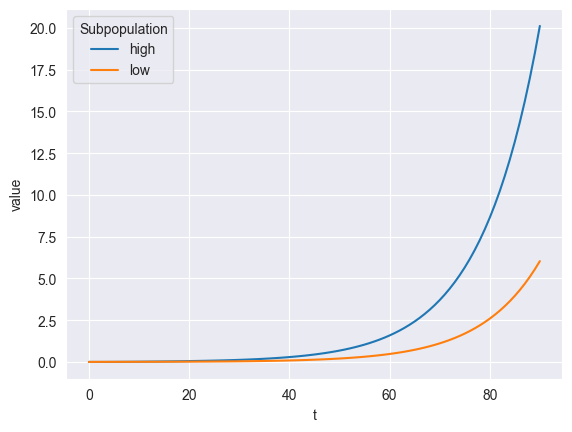

In [16]:
hospitalised_results = results_1_melted[results_1_melted['State']=='H']
sns.lineplot(hospitalised_results,x='t',y='value',hue='Subpopulation')

# 2.
## 2.1 Set up Seeders

In [17]:
from metacast import MultnomialSeeder

In [18]:
seeding_info = {'unhospitalised': {'E': 'sigma','I':'gamma'},
                'hospitalised': {'E': 'sigma','I':'gamma', 'H':'eta'},
                }
seeder = MultnomialSeeder(seeding_info)
seeder.set_seed(42) # This class uses random number generation (rng) use set_seed function to set rng seed.

## 2.2 Setup Populations with seeder

In [19]:
prevelance = 0.1
low_risk_total_infected = low_risk_population*prevelance
low_risk_infected = seeder.seed_infections(n=low_risk_total_infected,
                                           branch_probability={'unhospitalised': 1- parameters['p_[low]'] ,'hospitalised': parameters['p_[low]']},
                                           parameters=parameters)
low_risk_infected

{'E': 26655, 'H': 283, 'I': 63062}

In [20]:
high_risk_total_infected = high_risk_population*prevelance
high_risk_infected = seeder.seed_infections(n=high_risk_total_infected*0.1,
                                            branch_probability={'unhospitalised': 1- parameters['p_[high]'] ,'hospitalised': parameters['p_[high]']},
                                            parameters=parameters)
high_risk_infected

{'E': 274, 'H': 106, 'I': 620}

In [21]:
y =np.zeros(metapop_model.num_state)
low_risk_state_pops = {'S':low_risk_population*(1-prevelance), **low_risk_infected}
for state, index in state_index_dict_low.items():
    if state in low_risk_state_pops:
        y[index] = low_risk_state_pops[state]

y

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       8.1000e+05, 2.6655e+04, 6.3062e+04, 2.8300e+02, 0.0000e+00,
       0.0000e+00])

In [22]:
high_risk_state_pops = {'S':high_risk_population*(1-prevelance), **high_risk_infected}
for state, index in state_index_dict_high.items():
    if state in high_risk_state_pops:
        y[index] = high_risk_state_pops[state]

y

array([9.0000e+04, 2.7400e+02, 6.2000e+02, 1.0600e+02, 0.0000e+00,
       8.1000e+05, 2.6655e+04, 6.3062e+04, 2.8300e+02, 0.0000e+00,
       0.0000e+00])

### 2.3 Run metapopulation model

In [23]:
results_2 = metapop_model.integrate(y,t)

In [24]:
results_2

high                                                      \
               S            E            I           H             R   
0   90000.000000   274.000000   620.000000  106.000000      0.000000   
1   88369.564597  1582.735169   842.064123  114.023639     91.612473   
2   86725.050327  2533.315604  1380.116194  136.089518    225.428357   
3   85039.066083  3250.160390  2102.132911  179.082593    429.558023   
4   83297.500422  3811.289843  2924.357772  244.552134    722.299828   
..           ...          ...          ...         ...           ...   
86  17902.137132    69.013713   345.424429  118.488360  72564.936366   
87  17885.131977    63.880815   320.051284  109.912133  72621.023790   
88  17869.390985    59.130185   296.523044  101.942398  72673.013388   
89  17854.820083    54.733291   274.708256   94.538211  72721.200160   
90  17841.332210    50.663737   254.484448   87.661125  72765.858480   

              low                                                         \
                S             E             I           H              R   
0   810000.000000  26655.000000  63062.000000  283.000000       0.000000   
1   795326.081372  31576.792388  63772.736422  313.662816    9010.727002   
2   780525.452939  35218.887127  65694.729226  340.562109   18220.368599   
3   765351.594745  38150.079300  68368.507356  365.613723   27764.204875   
4   749677.503801  40677.759754  71527.024147  389.932296   37727.780002   
..            ...           ...           ...         ...            ...   
86  161119.234186    621.123419   3109.280721   35.557938  735114.803735   
87  160966.187795    574.927333   2880.861065   32.983553  735545.040254   
88  160824.518867    532.171666   2669.053719   30.591316  735943.664432   
89  160693.380743    492.599620   2472.674523   28.368919  736312.976195   
90  160571.989888    455.973633   2290.620290   26.304803  736655.111386   

   observed_states  
               H_T  
0         0.000000  
1       120.304732  
2       259.434670  
3       429.260371  
4       636.602712  
..             ...  
86    29121.901034  
87    29140.431015  
88    29157.599293  
89    29173.504962  
90    29188.240043  

[91 rows x 11 columns]

### 2.4 Plotting hospitalisations

In [25]:
results_2['t'] = t
results_2_melted = results_2.melt(id_vars=['t'],var_name=['Subpopulation', 'State']) # melt results for using seaborn
results_2_melted

,t,Subpopulation,State,value
0,0,high,S,90000.000000
1,1,high,S,88369.564597
2,2,high,S,86725.050327
3,3,high,S,85039.066083
4,4,high,S,83297.500422
...,...,...,...,...
996,86,observed_states,H_T,29121.901034
997,87,observed_states,H_T,29140.431015
998,88,observed_states,H_T,29157.599293
999,89,observed_states,H_T,29173.504962


<Axes: xlabel='t', ylabel='value'>

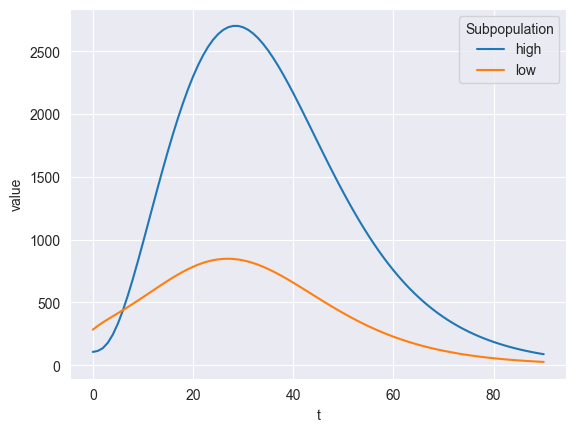

In [26]:
hospitalised_results = results_2_melted[results_1_melted['State']=='H']
sns.lineplot(hospitalised_results,x='t',y='value',hue='Subpopulation')

# 3. Two New Vaccines of known efficacy: Multi Dimension/Axis disease X model with flows between subpopulations.